In [1]:
# switch to main dir to fix imports
import os

if os.getcwd().endswith("notebooks"):
    os.chdir("..")
    print("using project root as working dir")

using project root as working dir


In [16]:
import networkx as nx
import numpy as np
from dataclasses import asdict
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from  matplotlib.ticker import PercentFormatter
import glob
import torch
from tqdm.notebook import tqdm

from src.args import Args
import src.graph_visualization as graph_visualization
import src.subgraphs as subgraphs
import src.graphs as graphs
from src.toroid import on_toroid

In [3]:
# start autoreload
%load_ext autoreload
%autoreload 2

# select device
device = "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")
print(f"using {device} device")

# global seaborn settings
sns.set_context("paper")
sns.set_style("darkgrid", {"grid.color": ".8"})
palette = "Dark2"

using cuda device


# Load data frames

In [6]:
# load data frame from folder
path = "./out/load"
files = glob.glob(os.path.join(path, "*.csv.zip"))
df = pd.concat((pd.read_csv(f) for f in files), ignore_index=True)

# either replace or concat
result = df
#df_result = pd.concat((df_result, df), ignore_index=True)

In [ ]:
# save data frame
result.to_csv(os.path.join(path, "./out/saved.csv.zip"), index=False, compression=dict(method='zip', archive_name=f"data.csv"))

# Plot BFS/DFS subgraph for RGG

In [ ]:
args = Args(
    graph_type="rgg",
    graph_size=500,
    # rgg specific settings
    rgg_avg_degree=10
)
graph = graphs.gen_graph(args)

bfs_sub = subgraphs.bfs_of(graph, args.epoch_graph_size)
dfs_sub = subgraphs.dfs_of(graph, args.epoch_graph_size)

# draw original graph (use to select good-looking graph)
fig_size = 10
fig, axs = plt.subplots(
    ncols=2,
    figsize=(fig_size * 2, fig_size)
)

axs[0].set_title(f"BFS", fontsize=12)
graph_visualization.draw_graph(
    ax=axs[0],
    graph=graph,
    subgraph=bfs_sub
)

axs[1].set_title(f"DFS", fontsize=12)
graph_visualization.draw_graph(
    ax=axs[1],
    graph=graph,
    subgraph=dfs_sub
)

plt.tight_layout(pad=2)
plt.savefig('./out/rgg_bfs_dfs.pdf')

# Average Degree

In [ ]:
args = Args(
    graph_type="t_rgg",
    graph_size=500,
    # rgg specific settings
    rgg_avg_degree=10
)

result = pd.DataFrame({})

for r in range(10):
    graph = graphs.gen_graph(args)
    result = pd.concat([
        result,
        pd.Series({
            "run_index": r,
            "avg_degree": np.array([d for _, d in graph.degree()]).sum() / nx.number_of_nodes(graph),
            **asdict(args),
        }).to_frame().T
    ], ignore_index=True)


avg_degree = result["avg_degree"].mean()
print(f"RGG should have avg degree {args.rg_avg_degree}, actually: {avg_degree}")

# Class Imbalance

In [ ]:
args_list = [
    Args(
        graph_type="rgg",
        graph_size=graph_size,
        # rgg specific settings
        rgg_avg_degree=10
    )
    for graph_size in [500, 1000, 2000, 3000, 4000, 5000]
    for _ in range(100)
]

result = pd.DataFrame({})

for r, args in enumerate(tqdm(args_list)):
    graph = graphs.gen_graph(args)
    n = nx.number_of_nodes(graph)
    e = nx.number_of_edges(graph)
    result = pd.concat([
        result,
        pd.Series({
            "run_index": r,
            "type": "graph",
            "n_nodes": n,
            "n_edges": e,
            "edge_imbalance": 2 * e / (n * (n - 1)),
            **asdict(args),
        }).to_frame().T
    ], ignore_index=True)

    sub = subgraphs.rjs_of(graph, args.epoch_graph_size, alpha=0.05)
    n = nx.number_of_nodes(sub)
    e = nx.number_of_edges(sub)
    result = pd.concat([
        result,
        pd.Series({
            "run_index": r,
            "type": "sub",
            "n_nodes": n,
            "n_edges": e,
            "edge_imbalance": 2 * e / (n * (n - 1)),
            **asdict(args),
        }).to_frame().T
    ], ignore_index=True)

    result.to_csv(f"./out/class_imbalance.csv.zip", index=False, compression=dict(method='zip', archive_name=f"data.csv"))

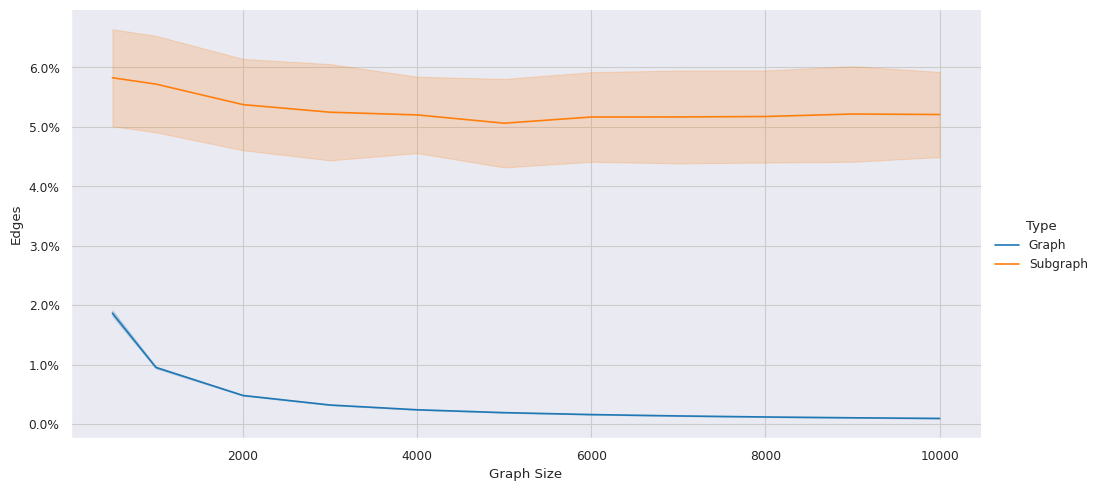

In [21]:
g = sns.relplot(
    data=result
        .assign(Type=result["type"].map({"graph": "Graph", "sub": "Subgraph"})),
    x="graph_size",
    y="edge_imbalance",
    hue="Type",
    kind="line",
    errorbar="sd",
    aspect=2,
)
g.set_axis_labels("Graph Size", "Edges")
g.ax.yaxis.set_major_formatter(PercentFormatter(1))

g.fig.savefig('./out/class_imbalance.pdf')

# Visualize graph on torus

In [ ]:
cmap = sns.color_palette("Spectral", as_cmap=True)
fig = plt.figure(figsize=(20, 10))

n = 100
theta = np.linspace(0, 2.*np.pi, n)
phi = np.linspace(0, 2.*np.pi, n)
theta, phi = np.meshgrid(theta, phi)
c, a = 2, 1
x = (c + a*np.cos(theta)) * np.cos(phi)
y = (c + a*np.cos(theta)) * np.sin(phi)
z = a * np.sin(theta)

ax1 = fig.add_subplot(121, projection='3d')
ax1.set_zlim(-3,3)
ax1.plot_surface(x, y, z, rstride=5, cstride=5, edgecolors=cmap(0.9))
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_zticks([])
ax1.grid(False)
plt.axis('off')


args = Args(
    graph_type="girg",
    graph_size=10
)

graph = graphs.gen_graph(args)
display_graph = on_toroid(graph)

node_colors = [
    cmap(0.0) if any(["shift" in d and d["shift"] != "none" for (_, _, d) in display_graph.edges(u, data=True)]) else cmap(1.0)
    for u in list(display_graph.nodes)
]
edge_colors = [
    cmap(0.1) if s != "none" else cmap(0.9)
    for (u, v, s) in display_graph.edges(data="shift")
]

ax2 = fig.add_subplot(122)
ax2.set_aspect('equal')
ax2.set_xlim(left=0, right=1)
ax2.set_ylim(bottom=0, top=1)
nx.draw_networkx(
    display_graph,
    pos=display_graph.nodes.data("pos"),
    node_color=node_colors,
    edge_color=edge_colors,
    with_labels=False,
    node_size=1.5,
    ax=ax2
)

plt.show()
fig.savefig("./out/torus.pdf")